In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt


In [3]:
# Define image transformations 
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [4]:
# Load Classification Model
classification_model = models.resnext50_32x4d()
classification_model.fc = nn.Sequential(
    nn.Linear(classification_model.fc.in_features, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2),  # 2 classes: Normal, Varicose
    nn.Softmax(dim=1)
)

# Load weights
classification_model.load_state_dict(torch.load("varicose_resnext50.pth", map_location=torch.device('cpu')))
classification_model.eval()  # Set to evaluation mode


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [5]:
import torch

# Load the saved model
staging_model_saved = torch.load("varicose_staging_resnext50.pth", map_location=torch.device('cpu'))

# Print model keys (Check fc layer shape)
for key, value in staging_model_saved.items():
    print(f"{key}: {value.shape}")


conv1.weight: torch.Size([64, 3, 7, 7])
bn1.weight: torch.Size([64])
bn1.bias: torch.Size([64])
bn1.running_mean: torch.Size([64])
bn1.running_var: torch.Size([64])
bn1.num_batches_tracked: torch.Size([])
layer1.0.conv1.weight: torch.Size([128, 64, 1, 1])
layer1.0.bn1.weight: torch.Size([128])
layer1.0.bn1.bias: torch.Size([128])
layer1.0.bn1.running_mean: torch.Size([128])
layer1.0.bn1.running_var: torch.Size([128])
layer1.0.bn1.num_batches_tracked: torch.Size([])
layer1.0.conv2.weight: torch.Size([128, 4, 3, 3])
layer1.0.bn2.weight: torch.Size([128])
layer1.0.bn2.bias: torch.Size([128])
layer1.0.bn2.running_mean: torch.Size([128])
layer1.0.bn2.running_var: torch.Size([128])
layer1.0.bn2.num_batches_tracked: torch.Size([])
layer1.0.conv3.weight: torch.Size([256, 128, 1, 1])
layer1.0.bn3.weight: torch.Size([256])
layer1.0.bn3.bias: torch.Size([256])
layer1.0.bn3.running_mean: torch.Size([256])
layer1.0.bn3.running_var: torch.Size([256])
layer1.0.bn3.num_batches_tracked: torch.Size([])


In [6]:
# Load Staging Model
staging_model = models.resnext50_32x4d()

# Update FC layer with the correct dimensions from saved model
staging_model.fc = nn.Sequential(
    nn.Linear(2048, 256),  # Match the saved model shape
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 4),  # 4 classes for staging
    nn.Softmax(dim=1)
)

# Load weights again
staging_model.load_state_dict(torch.load("varicose_staging_resnext50.pth", map_location=torch.device('cpu')))
staging_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [7]:
def predict_varicose_stage(image_path):
    # Load and preprocess image (Convert to RGB to handle RGBA issues)
    img = Image.open(image_path).convert("RGB")  # Convert RGBA to RGB if needed
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    
    # Classification Model Prediction
    with torch.no_grad():
        class_output = classification_model(img_tensor)
        _, class_pred = torch.max(class_output, 1)
    
    class_names = ["Normal", "Varicose Veins"]
    predicted_class = class_names[class_pred.item()]
    
    if predicted_class == "Normal":
        print(f"Prediction: {predicted_class}")
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_class}")
        plt.axis("off")
        plt.show()
        return predicted_class  # No need for staging
    
    # Staging Model Prediction
    with torch.no_grad():
        stage_output = staging_model(img_tensor)
        _, stage_pred = torch.max(stage_output, 1)
    
    # Stage Names & Descriptions
    stage_details = {
        "Stage-1:Mild": "Spider veins (telangiectasia) - Small, web-like veins, no swelling.",
        "Stage-2:Moderate": "Varicose veins visible - Twisted, enlarged veins, mild discomfort.",
        "Stage-3:Severe": "Swelling (Edema) - Veins bulging, leg swelling without skin changes.",
        "Stage-4:Critical": "Skin changes, ulcers - Skin darkening, open sores, blood pooling."
    }
    
    stage_names = list(stage_details.keys())
    predicted_stage = stage_names[stage_pred.item()]
    stage_description = stage_details[predicted_stage]
    
    print(f"Prediction: {predicted_class} - {predicted_stage}")
    print(f"Description: {stage_description}")
    
    # Display image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class} - {predicted_stage}")
    plt.axis("off")
    plt.show()
    
    return predicted_class, predicted_stage, stage_description


Prediction: Varicose Veins - Stage-2:Moderate
Description: Varicose veins visible - Twisted, enlarged veins, mild discomfort.


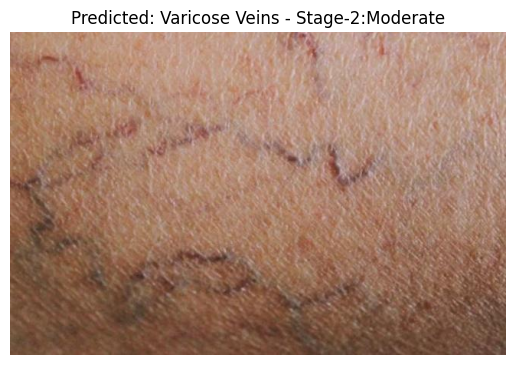

('Varicose Veins',
 'Stage-2:Moderate',
 'Varicose veins visible - Twisted, enlarged veins, mild discomfort.')

In [8]:
image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/58_jpeg.rf.8522e59123b36d6d23b859456e609e22.jpg"  # Replace with actual path
predict_varicose_stage(image_path)


In [9]:
image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/image.png"  # Replace with actual path
predict_varicose_stage(image_path)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Vinod\\Downloads\\Varicose Vein Detection\\Varicose Vein Detection\\image.png'

Prediction: Varicose Veins - Stage-2:Moderate
Description: Varicose veins visible - Twisted, enlarged veins, mild discomfort.


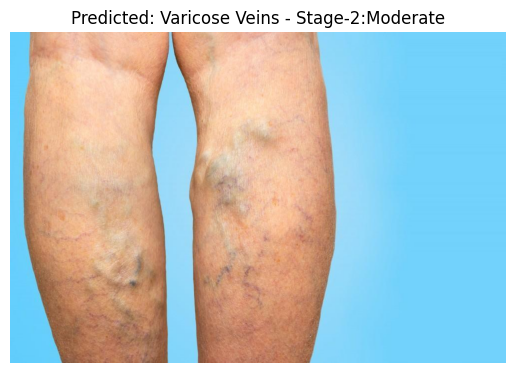

('Varicose Veins',
 'Stage-2:Moderate',
 'Varicose veins visible - Twisted, enlarged veins, mild discomfort.')

In [ ]:

image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/image.png"
predict_varicose_stage(image_path)

Prediction: Varicose Veins - Stage-1:Mild
Description: Spider veins (telangiectasia) - Small, web-like veins, no swelling.


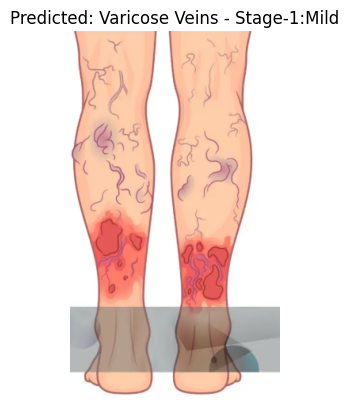

('Varicose Veins',
 'Stage-1:Mild',
 'Spider veins (telangiectasia) - Small, web-like veins, no swelling.')

In [ ]:

image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/image.png"
predict_varicose_stage(image_path)

Prediction: Varicose Veins - Stage-1:Mild
Description: Spider veins (telangiectasia) - Small, web-like veins, no swelling.


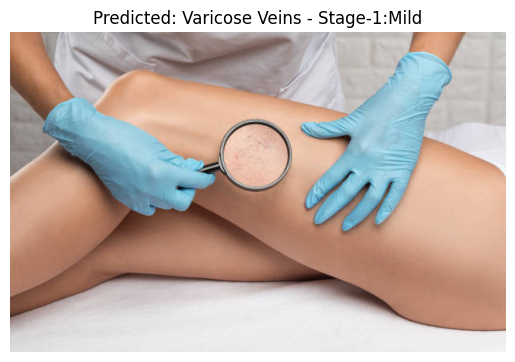

('Varicose Veins',
 'Stage-1:Mild',
 'Spider veins (telangiectasia) - Small, web-like veins, no swelling.')

In [ ]:

image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/test1.png"
predict_varicose_stage(image_path)

In [ ]:

image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/test4.png"
predict_varicose_stage(image_path)

NameError: name 'predict_varicose_stage' is not defined

Prediction: Varicose Veins - Stage-2:Moderate
Description: Varicose veins visible - Twisted, enlarged veins, mild discomfort.


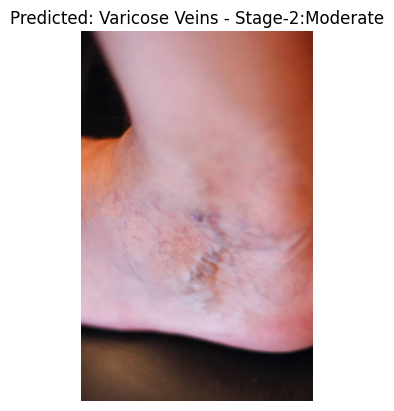

('Varicose Veins',
 'Stage-2:Moderate',
 'Varicose veins visible - Twisted, enlarged veins, mild discomfort.')

In [ ]:

image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/image.png"
predict_varicose_stage(image_path)

Prediction: Normal


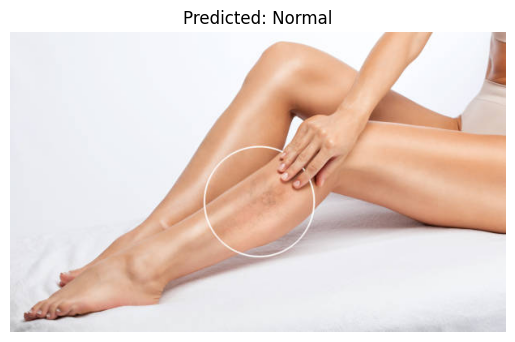

'Normal'

In [ ]:

image_path = "C:/Users/Vinod/Downloads/Varicose Vein Detection/Varicose Vein Detection/image.png"
predict_varicose_stage(image_path)